> Pacotes necessários

In [138]:
import numpy as np
import os

import scipy
from PIL import Image
import matplotlib.pylab as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
import importlib

from time import monotonic as timer

> Esta célula trata dos plots dos datasets com e sem preditions e a função que trata de fazer o parse do dataset

In [139]:
def plot_tagged_data(row,col,n_row,n_col,X,Y,parameters): 
    fig=plt.figure(figsize=(row,col))
    
    l,cache = feed_forward(X.T,parameters,activation_function)
    for n in range(row*col):
        img=np.reshape(X[n],(n_row,n_col))
        fig.add_subplot(row, col, n+1)
           
        if(l[0][n]>0.5):
    
            plt.imshow(img,interpolation='none',cmap='RdPu')
        else:
            plt.imshow(img,interpolation='none',cmap='cool')               
    plt.show()
    
def read_asc_data(filename):    
    f= open(filename,'r') 
    tmp_str=f.readline()
    tmp_arr=tmp_str[:-1].split(' ')
    N=int(tmp_arr[0]);n_row=int(tmp_arr[1]);n_col=int(tmp_arr[2])
    data=np.zeros([N,n_row*n_col+1])
    for n in range(N):
        tmp_str=f.readline()
        tmp_arr=tmp_str[:-1].split(' ')       
        for i in range(n_row*n_col+1):
            data[n][i]=int(tmp_arr[i])
    f.close() 
    return N,n_row,n_col,data

> Esta célula corre todas as funções de ativação e as suas derivadas

In [140]:
# sigmoid function
def sigmoid(z):
    s = 1 / (1 + np.exp(-z));
    return s;

# relu function
def relu(z):
    return np.where( z <= 0, 0 , z)

# swish function
def swish(z):
    s = z / (1 + np.exp(-z));
    return s;

#derivada swish
def der_swish(z):
    return (sigmoid(z)+z*sigmoid(1-sigmoid(z)))


#derivada sigmoid
def der_sigmoid(z):
    return sigmoid(1-sigmoid(z))

#derivada tangente hiperbólica
def der_tanh(z):
    return (1-np.power(z,2))

#derivada relu
def der_relu(z):
    z[z<=0] = 0
    z[z>0] = 1
    return z

#leaky_relu function
def leaky_relu(z):
    return np.where( z <= 0, 0.01*z, z)

#derivada leaky_relu
def der_leaky_relu(z):
    z[z<=0]=0.01
    z[z>0]=1
    return z

#normalization
def normalization(ew):
    return(ew/np.linalg.norm(ew,2))

> Esta célula inicializa os parãmetros de uma rede neuronal, neste caso temos apenas dois layers

> Input -> Hidden Layer -> Output


In [141]:
# size of the fst and the last layer, and the hidden layer
# assuming 1 hidden layer
def inicializar_parameters(n_x,n_h,n_y):
    
    #w1 = np.zeros((n_h,n_x))
    #w1 = normalization(w1)
    w1 = np.random.randn(n_h,n_x) * 0.01;
    b1 = np.zeros((n_h,1));
    
    #w2 = np.zeros((n_y,n_h))
    #w2 = normalization(w2)
    w2 = np.random.randn(n_y,n_h) * 0.01;
    b2 = np.zeros((n_y,1));

    parameters = {
        "w1" : w1,
        "b1" : b1,
        "w2" : w2,
        "b2" : b2
    }

    return parameters;


> Esta célula faz o feed forward da rede, neste caso temos que especificar as funções de ativação

> Input -> Função linear(z1) -> Função de Ativação -> Função linear(Z2) -> Função de Ativação(Sigmoid) (output)

In [142]:
# i use the non-linear activation function called than, in the output layer i use sigmoid, cause this is a binary classification problem.
def feed_forward(X,parameters,activation):
    
    
    w1 = parameters["w1"];
    b1 = parameters["b1"];
    w2 = parameters["w2"];
    b2 = parameters["b2"];

    #feed_foward
    Z1 = np.dot(w1,X) + b1; 

    if(activation == "tanh"):
        A1 = np.tanh(Z1);
    elif(activation == "relu"):
        A1 = relu(Z1);
    elif(activation == "sigmoid"):
        A1 = sigmoid(Z1);
    elif(activation == "leaky_relu"):
        A1 = leaky_relu(Z1);
    elif(activation == "swish"):
        A1 = swish(Z1);
        
    Z2 = np.dot(w2,A1) + b2;
    A2 = sigmoid(Z2);

    cache = {
        "Z1" : Z1,
        "A1" : A1,
        "Z2" : Z2,
        "A2" : A2
    }

    return A2, cache;

> Função custo

In [143]:
def calculate_cost(A2,Yt):
    #para não estar a fazer log de 0 acrescenta-se um eta
    e = 1e-8
    Cost = - np.sum(np.dot(Yt, np.log(A2+e).T) + np.dot(1 - Yt, np.log(1 - A2+e).T)) /m;  #cost function
    return Cost;


> Back propagation da rede, preciso as funções de ativação

In [144]:
def back_propagation(X,Y,cache,parameters,activation):

    A1 = cache["A1"];
    w1 = parameters["w1"];
    w2 = parameters["w2"];
    A2 = cache["A2"];
    
    dZ2 = A2 - Y;
    dW2 = np.dot(dZ2,A1.T)/m;
    dB2 = np.sum(dZ2, axis=1, keepdims = True)/m;
    
    if(activation == "relu"):
        dZ1 = np.multiply(np.dot(w2.T,dZ2), der_relu(A1));
    if(activation == "tanh"):
        dZ1 = np.multiply(np.dot(w2.T,dZ2), 1 - np.power(A1, 2));
    if(activation == "sigmoid"):
        dZ1 = np.multiply(np.dot(w2.T,dZ2),der_sigmoid(A1));
    if(activation == "leaky_relu"):
        dZ1 = np.multiply(np.dot(w2.T,dZ2), der_leaky_relu(A1));
    if(activation == "swish"):
        dZ1 = np.multiply(np.dot(w2.T,dZ2), der_swish(A1));
        
    dW1 = np.dot(dZ1,X.T)/m;
    dB1 = np.sum(dZ1,axis = 1, keepdims = True)/m;

    grads = {
        "dW2" : dW2,
        "dB2" : dB2,
        "dW1" : dW1,
        "dB1" : dB1
    }

    return grads;


> Otimização de parâmetros, feito após ter corrido o back propagation, e obtido os respetivos gradientes

In [145]:
def otimize_parameters(parameters,grads,learning_rate):
    
    w1 = parameters["w1"];
    w2 = parameters["w2"];
    b1 = parameters["b1"];
    b2 = parameters["b2"];

    
    dW2 = grads["dW2"];
    dB2 = grads["dB2"];
    dW1 = grads["dW1"];
    dB1 = grads["dB1"];

    #uptade de parameters
    w2 = w2 - learning_rate * dW2;
    w1 = w1 - learning_rate * dW1;
    b1 = b1 - learning_rate * dB1;
    b2 = b2 - learning_rate * dB2;

    parameters = {
        "w1" : w1,
        "b1" : b1,
        "w2" : w2,
        "b2" : b2
    }

    return parameters;

> Esta célula reparte o dataset em vários batches

In [146]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    inputs = inputs.T
    targets = targets.T
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

> Modelo

In [161]:
Xt.shape

(144, 900)

In [180]:
def model(n_h,epochs,learning_rate,activation,batch_size,show_info,shuffle=True):

    np.random.seed(3) # we set up a seed so that your output matches ours although the initialization is random.
    parameters = inicializar_parameters(Xt.shape[0],n_h,Yt.shape[0]);
    
    #previous_cost vai ser similar a um eraly stopping neste problema, qd o custo não diminuir em 100 epochs para de treinar
    previous_cost = 1e3
    previous_val_accuracy = 1
    cost_arr=[]
    costval_arr=[]
    acc_train = []
    acc_val = []
    
    times = []#array with the times of each epoch
    
    for i in range(0,epochs):
        
        begin = timer()
        
        
        for batch in iterate_minibatches(Xt, Yt, batch_size, shuffle=True):
            
            x_batch, y_batch = batch
            
        
            A2, cache = feed_forward(x_batch.T,parameters,activation);
            grads = back_propagation(x_batch.T,y_batch.T,cache,parameters,activation);
            parameters = otimize_parameters(parameters,grads,learning_rate);            
        
            #calculate the time in seconds
        end = timer()
        time = end-begin
        times.append(time)
        
        
        if(i%100 == 0):
            
            #validation cost calcultated here
            A2_train, _ = feed_forward(Xt,parameters,activation);
            A2_val, _ = feed_forward(Xval,parameters,activation);
            
            A2_val_plot = np.where(A2_val >= 0.5, 1 , 0)
            A2_plot = np.where(A2_train >= 0.5, 1 , 0)
            
            accuracy_train = np.sum(np.equal(A2_plot,Yt))/(A2_train.shape[1])
            accuracy_val = np.sum(np.equal(A2_val_plot,Yval))/(A2_val.shape[1])
            
            acc_train.append(accuracy_train)
            acc_val.append(accuracy_val)
            
            
            cost = calculate_cost(A2_train,Yt)
            if(show_info == True):
                print("Cost of iteration " + str(i) + " = " + str(cost) + " and accuracy train of = " + str(accuracy_train));
            costval = calculate_cost(A2_val,Yval)
            if(show_info == True):
                print("Cost of validation iteration " + str(i) + " = " + str(costval) + " and accuracy val of = " + str(accuracy_val));
            
            #parar se o cost em 100 iterações doir maior ao igual que o de -100 iterações
            if(cost >= previous_cost):
                break

            previous_cost = cost
            cost_arr.append(cost)
            costval_arr.append(costval)
    
    if(show_info == True):
        figure(figsize=(15, 5))
        #primeiros dois números são as shapes,  linha e coluna, 3 index é onde está o gráfico
        plt.subplot(1, 2, 1)
        plt.plot(cost_arr)
        plt.plot(costval_arr)
        plt.title('model cost')
        plt.ylabel('loss')
        plt.xlabel('iteration')
        plt.legend(['train', 'validation'], loc='upper left')
    

        plt.subplot(1, 2, 2)    
        plt.plot(acc_train)
        plt.plot(acc_val)
        plt.title('model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('iteration')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
    
    return cache,parameters,times,accuracy_train,accuracy_val

find 1500 images of 12 X 12 pixels

Information about the dataset : 
We have 444.0 images with label = 1 and 456.0 images with label = 0

Cost of iteration 0 = 0.6931201346962613 and accuracy train of = 0.5788888888888889
Cost of validation iteration 0 = 0.23104376273259994 and accuracy val of = 0.5533333333333333
Cost of iteration 100 = 0.6929898814469915 and accuracy train of = 0.5066666666666667
Cost of validation iteration 100 = 0.2309782477004938 and accuracy val of = 0.52
Cost of iteration 200 = 0.692826487804651 and accuracy train of = 0.5066666666666667
Cost of validation iteration 200 = 0.23090777506636292 and accuracy val of = 0.52
Cost of iteration 300 = 0.6925732539165614 and accuracy train of = 0.5066666666666667
Cost of validation iteration 300 = 0.2308129454312043 and accuracy val of = 0.52
Cost of iteration 400 = 0.6921418854947067 and accuracy train of = 0.5066666666666667
Cost of validation iteration 400 = 0.23066498822986953 and accuracy val of = 0.52
Cost of iterati

Cost of iteration 4900 = 0.04019887877720276 and accuracy train of = 1.0
Cost of validation iteration 4900 = 0.014339918194349618 and accuracy val of = 1.0
Cost of iteration 5000 = 0.03824669705247171 and accuracy train of = 1.0
Cost of validation iteration 5000 = 0.013648444347288608 and accuracy val of = 1.0
Cost of iteration 5100 = 0.03645194874782619 and accuracy train of = 1.0
Cost of validation iteration 5100 = 0.013012334995502755 and accuracy val of = 1.0
Cost of iteration 5200 = 0.03479816680115689 and accuracy train of = 1.0
Cost of validation iteration 5200 = 0.01242571503955158 and accuracy val of = 1.0
Cost of iteration 5300 = 0.03327047958238877 and accuracy train of = 1.0
Cost of validation iteration 5300 = 0.011883760792821198 and accuracy val of = 1.0
Cost of iteration 5400 = 0.031856045082522655 and accuracy train of = 1.0
Cost of validation iteration 5400 = 0.011381753836292552 and accuracy val of = 1.0
Cost of iteration 5500 = 0.030543050236777173 and accuracy train

Cost of iteration 10200 = 0.009416949851117495 and accuracy train of = 1.0
Cost of validation iteration 10200 = 0.0033819320237715228 and accuracy val of = 1.0
Cost of iteration 10300 = 0.00926846319215201 and accuracy train of = 1.0
Cost of validation iteration 10300 = 0.0033287551374365423 and accuracy val of = 1.0
Cost of iteration 10400 = 0.009124252492685211 and accuracy train of = 1.0
Cost of validation iteration 10400 = 0.003277105870824974 and accuracy val of = 1.0
Cost of iteration 10500 = 0.008984153863544913 and accuracy train of = 1.0
Cost of validation iteration 10500 = 0.0032269137933727482 and accuracy val of = 1.0
Cost of iteration 10600 = 0.008847989009705381 and accuracy train of = 1.0
Cost of validation iteration 10600 = 0.0031781293961924886 and accuracy val of = 1.0
Cost of iteration 10700 = 0.00871559956273206 and accuracy train of = 1.0
Cost of validation iteration 10700 = 0.003130696820736271 and accuracy val of = 1.0
Cost of iteration 10800 = 0.0085868483281600

Cost of iteration 15400 = 0.005029836853725493 and accuracy train of = 1.0
Cost of validation iteration 15400 = 0.0018088443274779623 and accuracy val of = 1.0
Cost of iteration 15500 = 0.004983529141613313 and accuracy train of = 1.0
Cost of validation iteration 15500 = 0.0017922210580976782 and accuracy val of = 1.0
Cost of iteration 15600 = 0.004938022600688168 and accuracy train of = 1.0
Cost of validation iteration 15600 = 0.0017758843500429193 and accuracy val of = 1.0
Cost of iteration 15700 = 0.004893293417684713 and accuracy train of = 1.0
Cost of validation iteration 15700 = 0.001759824958647126 and accuracy val of = 1.0
Cost of iteration 15800 = 0.004849309441871852 and accuracy train of = 1.0
Cost of validation iteration 15800 = 0.0017440346836067489 and accuracy val of = 1.0
Cost of iteration 15900 = 0.0048060723527440785 and accuracy train of = 1.0
Cost of validation iteration 15900 = 0.0017285130371748987 and accuracy val of = 1.0
Cost of iteration 16000 = 0.004763552337

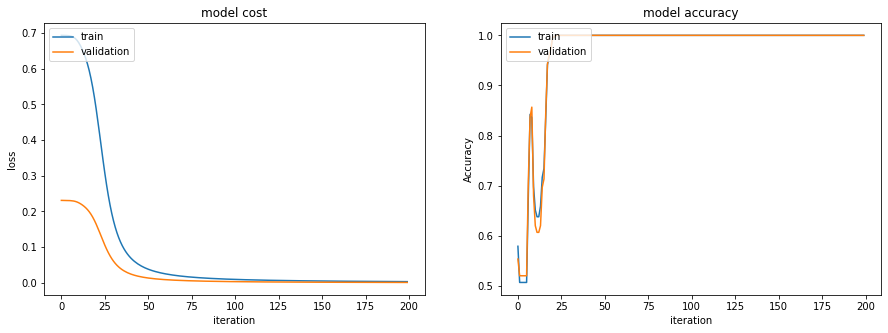

In [170]:
# =========== Setting dataset ================

#N,n_row,n_col,data=read_asc_data('dataSets/line600.txt')
N,n_row,n_col,data=read_asc_data('dataSets/square_circle.txt')

print('find %d images of %d X %d pixels' % (N,n_row,n_col))

hidden_nodes= 3
#plot_data(10,10,n_row,n_col,data)
Nt=int(N*0.6);I=n_row*n_col; #split training vs test sets

Nval=int(N*0.2);

Xt=data[:Nt,:-1];Yt=data[:Nt,-1]
Xval=data[Nt:Nval+Nt,:-1];Yval=data[Nt:Nval+Nt,-1]

Yt = Yt.reshape(len(Yt),1)
Yval=Yval.reshape(len(Yval),1)

np.place(Yt, Yt!=1, [0])
np.place(Yval, Yval!=1, [0])

m = Xt.shape[0]

Xt = Xt.T
Yt = Yt.T
Xval=Xval.T
Yval=Yval.T

print("\nInformation about the dataset : ")
print("We have " + str(np.sum(Yt)) + " images with label = 1 and " + str(Yt.shape[1]-np.sum(Yt)) + " images with label = 0\n")

cache,parameters,times,acc_train,acc_val = model(hidden_nodes,14000,0.01,"tanh",32,True)

In [181]:
#funções de ativação disponíveis por agora
# * Relu
# * Tanh
# * Sigmoid
# * Leaky_Relu
# * Swish

def activation_time(hidden_nodes):
    
    activations_time = []
    accuracys = []
    
    activations = ["swish","relu","sigmoid","leaky_relu","tanh"]
    
    for activation in activations:
        
        cache,parameters,times, acc_train, acc_val = model(hidden_nodes,1000,0.01,activation,32,False)
    
        activations_time.append(np.mean(times))
        accuracys.append([acc_train,acc_val])

    return activations_time,accuracys,activations

#fazemos com dois extremos, um muito baixo, 3 e outro alto, 40 para ver a diferença
activations_time_1, accuracy1, activations = activation_time(3)
activations_time_2, accuracy2, activations = activation_time(40)
#activations_time_3, activations = activation_time(100)

Activations = ['swish', 'relu', 'sigmoid', 'leaky_relu', 'tanh']
Accuracy train and val for 1 = [[0.5066666666666667, 0.52], [0.7755555555555556, 0.79], [0.5066666666666667, 0.52], [0.75, 0.75], [0.6977777777777778, 0.68]]


Text(0.5, 1.0, 'Tempo médio de ativação por epoch relativa a X neurónios')

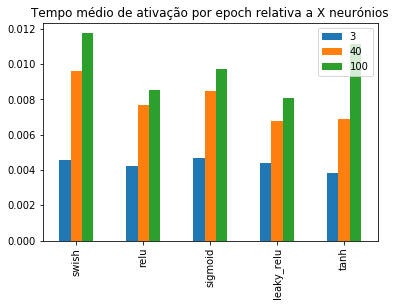

In [184]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print("Activations = " + str(activations))
print("Accuracy train and val for 1 = " + str(accuracy1))


X = activations
Y = activations_time_1
Z = activations_time_2
L = activations_time_3

df = pd.DataFrame(np.c_[Y,Z,L], index = X)
ax = df.plot(kind='bar')
ax.legend(["3", "40","100"])
ax.set_title("Tempo médio de ativação por epoch relativa a X neurónios")



(3, 144)
(1, 3)
***** ***** First Layer ***** *****


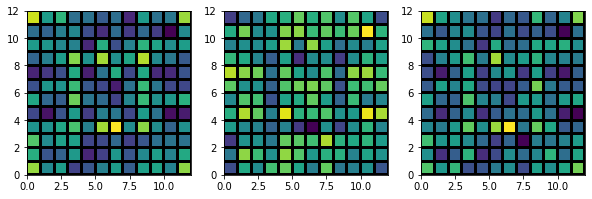

***** ***** *****  *****


***** ***** Second Layer ***** *****


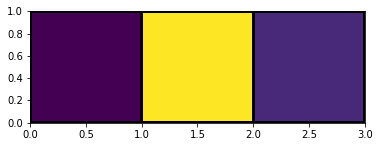

***** ***** *****  *****


In [166]:
#caso os pesos sejam maiores que 0.5 digo que é 1 caso contrário 0
def plot_weights(parameters,img_size):
    w1 = parameters["w1"]
    w2 = parameters["w2"]
    
    print(w1.shape)
    print(w2.shape)
    
    img = w1.reshape(hidden_nodes,img_size,img_size)
    
    plt.ion()
    plt.figure(figsize=(10, 10))
    
    print("***** ***** First Layer ***** *****")
    for i in range(hidden_nodes):
        ax = plt.subplot(1, hidden_nodes, i + 1)
        plt.pcolormesh(img[i], edgecolors='k', linewidth=2)
        ax = plt.gca()
        ax.set_aspect('equal')         
    
        
    plt.show(block=True)
    print('***** ***** *****  *****')

    
    print("\n\n***** ***** Second Layer ***** *****")
    
    plt.ion()
    plt.pcolormesh(w2, edgecolors='k', linewidth=2)
    ax = plt.gca()
    ax.set_aspect('equal')         
    plt.show(block=True)
    plt.pause(0.001)
    print('***** ***** *****  *****')    

plot_weights(parameters,n_row)

(3, 1)
This is the Z for the = 1.0 output
***** ***** First Layer ***** *****


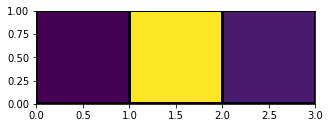

***** ***** *****  *****


***** ***** Second Layer ***** *****


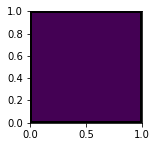

***** ***** *****  *****


In [167]:
def plot_Z_per_input(input_image,parameters,output):
    
    A2, cache = feed_forward(input_image,parameters,"tanh");
    
    Z1 = cache["Z1"]
    Z2 = cache["Z2"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    print(Z1.shape)
    
    plt.ion()
    plt.figure(figsize=(5, 5))
    
    print("This is the Z for the = " + str(output) + " output")
    
    print("***** ***** First Layer ***** *****")
    
    plt.ion()
    plt.pcolormesh(Z1.T, edgecolors='k', linewidth=2)
    ax = plt.gca()
    ax.set_aspect('equal')         
    plt.show(block=True)
    plt.pause(0.001)
    
    print('***** ***** *****  *****')

    plt.figure(figsize=(2, 3))
    print("\n\n***** ***** Second Layer ***** *****")
    
    plt.ion()
    plt.pcolormesh(Z2, edgecolors='k', linewidth=2)
    ax = plt.gca()
    ax.set_aspect('equal')         
    plt.show(block=True)
    plt.pause(0.001)
    print('***** ***** *****  *****')    

x = Xt[:,4].reshape(Xt[:,0].shape[0],1)
y = Yt[:,4][0]

plot_Z_per_input(x,parameters,y)


----------  Confusion matrix on train set with 900 images ------------


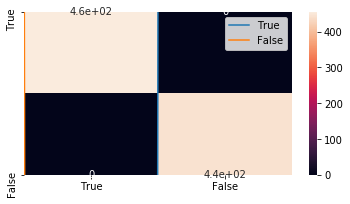

----------  Confusion matrix on test set with 300 ------------


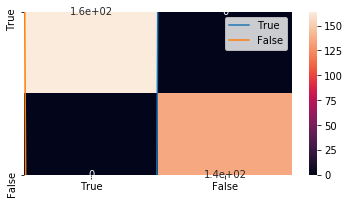

In [168]:
from string import ascii_uppercase
from pandas import DataFrame
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix

def my_confusion_matrix(parameters):
    
    Ne=N-Nt;
    Xe=data[Nt+Nval:N,:-1];Ye=data[Nt+Nval:N,-1]; 
    Ye = np.where(Ye == -1, 0,1)
    Xe = Xe.T; Ye = Ye.T #test set
    
    #Xt,Yt -> train set
    
    predictions_train_set , _ = feed_forward(Xt,parameters,activation_function)
    predictions_test_set , _ = feed_forward(Xe,parameters,activation_function)
    predictions_train_set = np.where(predictions_train_set < 0.5 , 0 , 1) 
    predictions_test_set = np.where(predictions_test_set < 0.5 , 0 , 1) 
    
    labels = [0,1]
    columns = ['True','False']
    
    print("----------  Confusion matrix on train set with " + str(Yt.shape[1]) + " images ------------")
    
    #data
    y_test = Yt.T
    predic = predictions_train_set.T

    #confusion matrix
    confm = confusion_matrix(y_test, predic,labels)
    #confusion matrix to datafram
    df_cm = DataFrame(confm, index=columns, columns=columns)
    df_cm.plot(figsize=(6,3));
    
    #plot
    ax = sn.heatmap(df_cm, annot=True)
    plt.show()
    #same thing on test set
    print("----------  Confusion matrix on test set with " + str(Ye.shape[0]) + " ------------")
    y_test = Ye.T
    predic = predictions_test_set.T
    
    confm = confusion_matrix(y_test, predic)
    df_cm = DataFrame(confm, index=columns, columns=columns)
    df_cm.plot(figsize=(6,3));
    ax = sn.heatmap(df_cm, annot=True)
    
my_confusion_matrix(parameters)

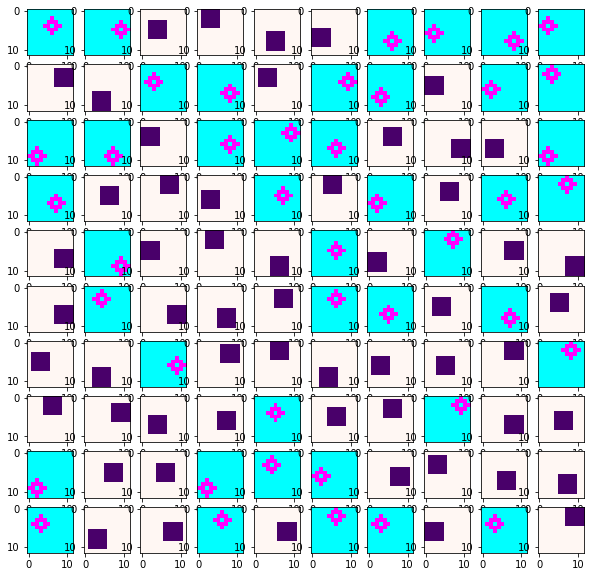

In [119]:
Ne=N-Nt;
Xe=data[Nt:N,:-1];Ye=data[Nt:N,-1];
Ye = np.where(Ye == -1, 0,1)
plot_tagged_data(10,10,n_row,n_col,Xe,Ye,parameters)